In [61]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eig
from scipy.sparse.linalg import eigsh,eigs
import os
import time
# torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [62]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=12 , out_num=5,hidden_num=16):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [63]:
def training(model,device,dtype,epoch,batch,lr):
    loss_fn=torch.nn.MSELoss()
    init_time=time.time()
    loss_list=[]
    
    alpha_list=[]
    eig_list=[]
    for i in range(45):
        alpha_target=torch.load(f'./target_alpha/alpha_200_64_{i+1}.pt').to(device=device,dtype=dtype)
        eig_data=torch.load(f'./data_eigenvalue/eigenvalues_200_64_{i+1}.pt').to(device=device,dtype=dtype)
        alpha_list.append(alpha_target)
        eig_list.append(eig_data)
    alpha_target=torch.cat(alpha_list,dim=0)
    eig_data=torch.cat(eig_list,dim=0)
    print('data loaded successfully ! ')
    
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=200,threshold=1e-4)
    epoch=len(alpha_target)
        
    for _ in range(3):
        ids=torch.randperm(len(alpha_target))
        alpha_target=alpha_target[ids]
        eig_data=eig_data[ids]
        for i in range(epoch):
            target_temp=alpha_target[i].to(device=device,dtype=dtype)
            data_temp=eig_data[i].to(device=device,dtype=dtype)
            
            optimizer.zero_grad()
            output=model(data_temp)
            loss=loss_fn(output,target_temp)
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.item())
            if i%10==0:
                print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
            if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}_{batch}.pth')
            if i>1000:scheduler.step(loss)
            if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
        print('terminal epoch: ',i+1)
        torch.save(model.state_dict(),f'./model_para/model_para_{lr}_{batch}.pth')
        if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
        
    return loss_list

In [64]:
def train (lr,batch):
    dtype=torch.float64
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epoch=1000
    
    model=Mynetwork().to(device=device,dtype=dtype)
    t_0=time.time()
    model.train()
    loss_list=training(model,device,dtype,epoch,batch,lr)    
    print('program ended here , time cost: ', time.time()-t_0)
    
    plt.plot(loss_list)
    plt.show()
    
    return model

/tmp/ipykernel_278330/4192077583.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  alpha_target=torch.load(f'./target_alpha/alpha_200_64_{i+1}.pt').to(device=device,dtype=

data loaded successfully ! 
epoch:0,loss:730.900140462576,time:0.18946552276611328,lr:0.01
epoch:10,loss:15.957670991786655,time:0.20814752578735352,lr:0.01
epoch:20,loss:1.5552413301980352,time:0.22446656227111816,lr:0.01
epoch:30,loss:0.29594890771743865,time:0.23996376991271973,lr:0.01
epoch:40,loss:0.11050325582334186,time:0.256788969039917,lr:0.01
epoch:50,loss:0.0617377015711919,time:0.2719573974609375,lr:0.01
epoch:60,loss:0.046283146163556055,time:0.28900837898254395,lr:0.01
epoch:70,loss:0.03189195592525539,time:0.3052046298980713,lr:0.01
epoch:80,loss:0.030165014382038027,time:0.3202188014984131,lr:0.01
epoch:90,loss:0.026230417684258003,time:0.33545923233032227,lr:0.01
epoch:100,loss:0.021460527124638487,time:0.3537931442260742,lr:0.01
epoch:110,loss:0.028206378909373997,time:0.37119221687316895,lr:0.01
epoch:120,loss:0.02641073041554484,time:0.38973236083984375,lr:0.01
epoch:130,loss:0.025336997475070722,time:0.40758705139160156,lr:0.01
epoch:140,loss:0.024905717359684266,t

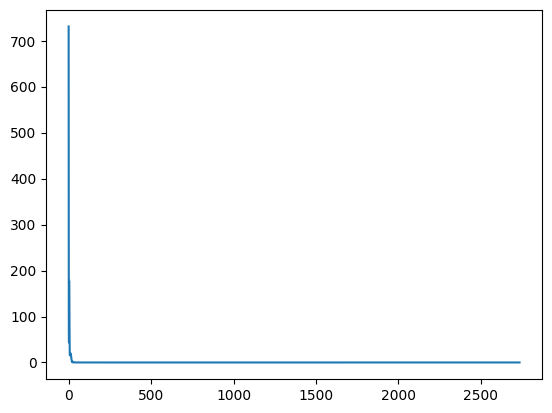

In [65]:
lr=1e-2
batch=64
model=train(lr=lr,batch=batch)

In [66]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

alpha_list=[]
eig_list=[]
for i in range(45,50):
    alpha_target=torch.load(f'./target_alpha/alpha_200_64_{i+1}.pt').to(device=device,dtype=dtype)
    eig_data=torch.load(f'./data_eigenvalue/eigenvalues_200_64_{i+1}.pt').to(device=device,dtype=dtype)
    alpha_list.append(alpha_target)
    eig_list.append(eig_data)
test_target=torch.cat(alpha_list,dim=0)
test_data=torch.cat(eig_list,dim=0)

/tmp/ipykernel_278330/4088021827.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  alpha_target=torch.load(f'./target_alpha/alpha_200_64_{i+1}.pt').to(device=device,dtype=

In [67]:
model_test=Mynetwork().to(device=device,dtype=dtype)
model_test.load_state_dict(torch.load(f'./model_para/model_para_{lr}_{batch}.pth',weights_only=True))
model_test.eval()
loss_fn=torch.nn.L1Loss()

mean error:  0.05723872293242504
max error:  0.07227816057549288
min error:  0.0448124058174914
std error:  0.004058864712773239


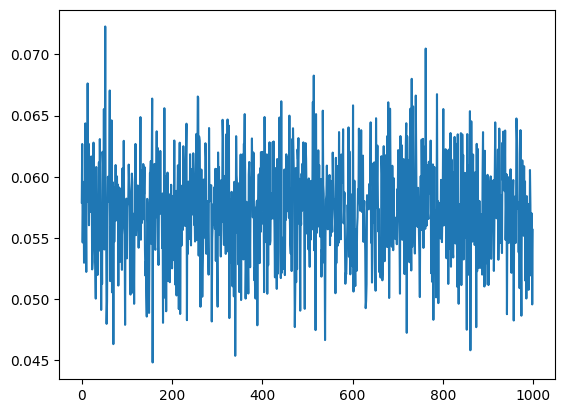

In [68]:
error_list=[]
for i in range(len(test_data)):
    output=model_test(test_data[i])
    error=loss_fn(output,test_target[i])
    error_list.append(error.item())
print('mean error: ',np.mean(error_list))
print('max error: ',np.max(error_list))
print('min error: ',np.min(error_list))
print('std error: ',np.std(error_list))
plt.plot(error_list)
plt.show()


In [69]:
n=np.random.randint(0,len(test_data))
m=np.random.randint(0,len(test_data[n]))
print(n,m)
output=model_test(test_data[n][m])
print(output)
expected=test_target[n][m]
print(expected)
print(f'error: {loss_fn(output,expected)}')



440 16
tensor([ 1.1302,  0.0117,  0.0035, -0.0146, -0.0112], device='cuda:0',
       dtype=torch.float64, grad_fn=<ViewBackward0>)
tensor([ 1.2555, -0.0180,  0.0013,  0.0023,  0.0060], device='cuda:0',
       dtype=torch.float64)
error: 0.03824850746366112


In [70]:
##用的截断的区间长度越长,因为离散化微分方程的时候使用了狄利克雷边界条件,也就是两端函数值为0,相当于超出边界范围的地方是一个无穷高势,这样我

### 我目前写了一个一维薛定谔方程势能取多项式形式:V(x)=a_0+a_1*x^2+a_2*x^4+a_3*x^6 的情况下,先采用离散化微分方程变成矩阵,进而求解出模最小的前10个本征值的近似值,先通过程序产生大量的(本征值)-(势能系数)数据对,用来训练和测试,然后再用这些数据对来进行网络的训练和下降.


### 计算方案,计算截断的区间是[-5,5],薛定谔方程中的常数取为h_bar=1,m=1,参数a_i(i=0,1,2,3)全部取在[-4,.4]范围内
### 方程离散化,将[-5,5]区间分为2001段,这样去掉边界的两个点以后,用于计算的点有2000个,对应的矩阵也就是2000阶的三对角矩阵.
### 使用scipy.sparse.linalg.eigsh来计算前10个本征值(绝对值最小的10个),一共计算了1000*64个方程作为训练数据,100*64个方程作为测试集
### 利用1000*64个[10本征值,4个势能系数]数据对来训练一个 10->64->64->64->4 (深度为3,宽度为64,激活函数为ELU)的网络,总共使用数据重复训练5次(每次都会随机打乱1000个数据对batch(size=64)的顺序),学习率调节器选择ReduceLROnPlateau,最后训练得到的网络在测试集上的测试结果大概是4个参数的输出与真实值的差的绝对值的平均值基本都在0.06~0.11之间.

### 先说结果,我测试了在
### 碰到的一些问题总结一下:
### 1.一个是训练的时候,区间的截断有些麻烦,因为要保证截断区间之外的波函数占总比例要很小,这样才能保证截断计算出来的能级接近于真实的能级.所以就需要考虑所有参数调节范围内的势函数对应的可以截断的位置都小于截断长度
### 2.但是截断长度也不能取太大,不然就需要增加离散点的数目从而保持模拟的区间粒度足够精细,否则对于势能迅速攀高的情况,波函数会非常集中于原点附近,导致计算精度很低,本征值的计算精度也就很差.